# Result for **FullConnect+MNIST**
### This notebook is for seed $42$. The results in the paper are the average of $5$ times with seeds in $[1, 19, 31, 42, 80]$

## Libraries

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Subset

import os
import random
import numpy as np
import pandas as pd
import copy
import time

import matplotlib
import matplotlib.pyplot as plt
from matplotlib.pyplot import MultipleLocator

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: dlopen(/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/torchvision/image.so, 0x0006): Symbol not found: __ZN3c106detail19maybe_wrap_dim_slowExxb
  Referenced from: <3F789787-FE38-3CE7-8599-064BDD0416EE> /Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/torchvision/image.so
  Expected in:     <3F9923D2-81A5-3EC8-9739-EC0C1C816132> /Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/torch/lib/libc10.dylib
  warn(f"Failed to load image Python extension: {e}")


## Models

In [2]:
# MNIST Fully Connected Net ----------------------------------------------------
class MNISTNet(nn.Module):
    def __init__(self):
        super(MNISTNet, self).__init__()
        self.fc1 = nn.Linear(28 * 28, 512)
        self.fc2 = nn.Linear(512, 10)

    def forward(self, x):
        # flatten image input
        x = x.view(-1, 28 * 28)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x


class MNISTNet_copy(nn.Module):
    def __init__(self):
        super(MNISTNet_copy, self).__init__()
        self.fc1 = nn.Linear(28 * 28, 512)
        self.fc2 = nn.Linear(512, 10)

    def forward(self, x):
        # flatten image input
        x = x.view(-1, 28 * 28)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

## Prepare data

In [3]:
def create_loaders(dataset_name, n_workers, batch_size):
    train_data, test_data = load_data(dataset_name)
    train_loader_workers = dict()
    n = len(train_data)
    
    # preparing iterators for workers
    indices = np.arange(n)
    np.random.shuffle(indices)
    a = np.int64(np.floor(n / n_workers))
    top_ind = a * n_workers
    seq = range(a, top_ind, a)
    split = np.split(indices[:top_ind], seq)
    b = 0
    for ind in split:
        train_loader_workers[b] = DataLoader(Subset(train_data, ind), batch_size=batch_size, shuffle=True)
        b = b + 1
    test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False)

    return train_loader_workers, test_loader


def load_data(dataset_name):
    if dataset_name == 'mnist':
        transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize((0.1307,), (0.3081,))
        ])
        train_data = datasets.MNIST(root='./data', train=True,
                                    download=True, transform=transform)
        test_data = datasets.MNIST(root='./data', train=False,
                                   download=True, transform=transform)
    elif dataset_name == 'fashionmnist':
        transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize((0.1307,), (0.3081,))
        ])
        train_data = datasets.MNIST(root='./data', train=True,
                                    download=True, transform=transform)
        test_data = datasets.MNIST(root='./data', train=False,
                                   download=True, transform=transform)


    elif dataset_name == 'cifar10':
        transform_train = transforms.Compose([
            transforms.RandomCrop(32, padding=4),
            transforms.RandomHorizontalFlip(),
            transforms.ToTensor(),
            transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
        ])
        transform_test = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
        ])
        train_data = datasets.CIFAR10(root='./data', train=True,
                                      download=True, transform=transform_train)
        test_data = datasets.CIFAR10(root='./data', train=False,
                                     download=True, transform=transform_test)

    elif dataset_name == 'cifar100':
        transform_train = transforms.Compose([
            transforms.RandomCrop(32, padding=4),
            transforms.RandomHorizontalFlip(),
            transforms.RandomRotation(15),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.5070751592371323, 0.48654887331495095, 0.4409178433670343],
                                 std=[0.5070751592371323, 0.48654887331495095, 0.4409178433670343])
        ])
        transform_test = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.5070751592371323, 0.48654887331495095, 0.4409178433670343],
                                 std=[0.5070751592371323, 0.48654887331495095, 0.4409178433670343])
        ])
        train_data = datasets.CIFAR100(root='./data', train=True,
                                       download=True, transform=transform_train)
        test_data = datasets.CIFAR100(root='./data', train=False,
                                      download=True, transform=transform_test)

    else:
        raise ValueError(dataset_name + ' is not known.')

    return train_data, test_data

## Parameter and Setup

In [4]:
# Hyperparameters
RANDOM_SEED = 42
lr = 0.005
BATCH_SIZE = 50
NUM_EPOCHS = 20
NUM_WORKERS = 4
D = 10  # compute thread
h = 0.01  # sparse level 99%
h1= 0.005 # gsparse level
# h2= 0.01 # gsparse level 
# h3= 0.005 # gsparse level 
# h4= 0.001 # gsparse level 


if not os.path.exists('result'):
    os.mkdir('result')
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device: ", DEVICE)

Using device:  cpu


## Functions

In [5]:
def seed_torch(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)  # if you are using multi-GPU.
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True
    
    
def evaluate_accuracy(model, data_iter, device):
    acc_sum, num_epo = 0.0, 0
    for image, label in data_iter:
        image, label = image.to(device), label.to(device)
        acc_sum += (model(image).argmax(dim=1) == label).float().sum().item()
        num_epo += label.shape[0]
    return acc_sum / num_epo * 100


# 定义Top_k sparse
def prep_grad(x):
    x_flat = torch.unsqueeze(x, 0).flatten()
    dim = x.shape#dim代表维度，相当于有多少个数
    d = x_flat.shape[0]
    return x_flat, dim, d


def top_k_opt(x, h):
    """
    :param x: vector to sparsify
    :param h: density
    :return: compressed vector
    """
    x, dim, d = prep_grad(x)
    # number of coordinates kept保留的坐标数，保留top多少 r就是这个k的数量
    r = int(np.maximum(1, np.floor(d * h)))
    # positions of top_k coordinates topk的坐标位置，保留了值和索引
    _, ind = torch.topk(torch.abs(x), r)
    mask = torch.zeros_like(x)#生成与x相同的全0张量
    mask[ind] = 1#把索引那一行全置为1
    t = mask * x
    #上面是top-k
    t = t.reshape(dim)
    
    return t


def compt(old, new):
    result = 0
    for i in range(len(old)):
        result += ((old[i].view(-1) - new[i].view(-1)) ** 2).sum().item()
    return result

# Sparse

In [6]:
print("Sparse  lr:"+str(lr)+"--h:"+str(h)+"--epoch:"+str(NUM_EPOCHS)+"--worker:"+str(NUM_WORKERS))
seed_torch(RANDOM_SEED)
model = MNISTNet()
model.to(DEVICE)
loss = nn.CrossEntropyLoss()  # 损失函数

# prepare data
dataset_name = 'mnist'
train_loader_workers, test_loader = create_loaders(dataset_name, NUM_WORKERS, BATCH_SIZE)

NUM_PARAS = sum([1 for param in model.parameters()])
print("Number_parameter:", NUM_PARAS)
total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print("Element_parameter:", total_params)
total_params_sparse = 0
for p in model.parameters():
    x, dim, d = prep_grad(p)
    r = int(np.maximum(1, np.floor(d * h)))
    total_params_sparse += r
print("Element_parameter_sparse:", total_params_sparse)

error_worker = [[0 for col in range(NUM_PARAS)] for row in range(NUM_WORKERS)]
Loss_epoch = []
train_Acc_epoch = []
test_Acc_epoch = []
Loss_iter = []
Round_epoch = []
train_acc_iter = []
test_acc_iter = []

iter_num = 0
flag_acc = False

for epoch in range(NUM_EPOCHS):
    train_l_sum, train_acc_sum, num = 0.0, 0.0, 0.0
    train_loader_iter = [iter(train_loader_workers[w]) for w in range(NUM_WORKERS)]
    iter_steps = len(train_loader_workers[0])

    for batch_idx in range(iter_steps):
        model.train()
        grad_agg = [0 for col in range(NUM_PARAS)]
        for w_id in range(NUM_WORKERS):
            start_data_time = time.time()
            images, labels = next(train_loader_iter[w_id])
            images, labels = images.to(DEVICE), labels.to(DEVICE)
            end_data_time = time.time()
            
            start_model_time = time.time()
            y_hat = model(images)
            Loss = loss(y_hat, labels)
            Loss.backward()
            with torch.no_grad():
                p_id = 0
                for p in model.parameters():
                    g = lr * p.grad.data.clone().detach() + error_worker[w_id][p_id]
                    Tk_sparse = top_k_opt(g, h)
                    grad_agg[p_id] += Tk_sparse
                    error_worker[w_id][p_id] = g - Tk_sparse
                    p_id += 1
                    p.grad.zero_()
            end_model_time = time.time()
            start_communication_time = time.time()
            train_l_sum += Loss.item()
            train_acc_sum += (y_hat.argmax(dim=1) == labels).sum().item()
            num += labels.shape[0]
            end_communication_time = time.time()
            communication_time = end_data_time - start_data_time + end_communication_time - start_communication_time
            print(communication_time)
        with torch.no_grad():
            p_id = 0
            for p in model.parameters():
                p.data.add_(grad_agg[p_id], alpha=-1)
                p_id += 1
                p.grad.zero_()

        # LOGGING
        if not (batch_idx + 1) % 100:
            print('Epoch: %03d/%03d | Batch %04d/%04d | Cost: %.4f'
                  % (epoch + 1, NUM_EPOCHS, batch_idx + 1, len(train_loader_workers[0]), Loss.item()))
        iter_num += 1
        if not iter_num % 100:
            model.eval()
            with torch.no_grad():
                test_acc_it = evaluate_accuracy(model, test_loader, DEVICE)
                Loss_iter.append(train_l_sum / (num / BATCH_SIZE))
                train_acc_iter.append(train_acc_sum / num * 100)
                test_acc_iter.append(test_acc_it)
#             if test_acc_it > 97.0 and not flag_acc:
#                 flag_acc = True
#                 print("*" * 100)
#                 print("Iter_num:", iter_num, "Test_acc", test_acc_it, "Comm_round:", iter_num * 4)  # 10 workers
#                 print("*" * 100)
            if test_acc_it < 97.0 and not flag_acc:
                Round_epoch.append(iter_num* 4*4070*32 )
          
         

    
                
            if test_acc_it > 97.0 and not flag_acc:
                flag_acc = True
                Round_epoch.append(iter_num* 4*4070*32 )
                print("*" * 100)
                print("Iter_num:", iter_num, "Test_acc", test_acc_it, "Comm_round:", iter_num * 4)  # 10 workers
                print("*" * 100)
    model.eval()
    with torch.no_grad():
        test_acc = evaluate_accuracy(model, test_loader, DEVICE)
        Loss_epoch.append(train_l_sum / (num / BATCH_SIZE))
        test_Acc_epoch.append(test_acc)
        train_Acc_epoch.append(train_acc_sum / num * 100)
    print('epoch %d, loss %.4f, train acc %.3f%%, test acc %.3f%%'
          % (epoch + 1, train_l_sum / (num / BATCH_SIZE), train_acc_sum / num * 100, test_acc))

print('Finished.')

list_write = []
list_write.append(Loss_epoch)
list_write.append(train_Acc_epoch)
list_write.append(test_Acc_epoch)
list_write.append(Round_epoch)

name = ['Loss', 'train-acc', 'test-acc','commd_round']
test = pd.DataFrame(index=name, data=list_write).T
test.to_csv("./result/"+"Sparse-full-round.csv", encoding='gbk')

list_write_iter = []
list_write_iter.append(Loss_iter)
list_write_iter.append(train_acc_iter)
list_write_iter.append(test_acc_iter)
list_write_iter.append(Round_epoch)

name_iter = ['Loss', 'train-acc', 'test-acc','commd_round']
test = pd.DataFrame(index=name_iter, data=list_write_iter).T
test.to_csv("./result/"+"Sparse-full-iter-round.csv", encoding='gbk')


Sparse  lr:0.005--h:0.01--epoch:20--worker:4


AttributeError: module 'torch' has no attribute '_six'

# SGD

## Plotting

In [ ]:
# Record once every 100 iterations, and 10 workers need to communicate in each iteration
original_num = 1000
k=1
print("original communication number:", original_num)

TASGS_data = pd.read_csv("./result/"+"TASGS-full-iter.csv")
SASG_data = pd.read_csv("./result/"+"SASG-full-iter.csv")
LASG_data = pd.read_csv("./result/"+"LASG-full-iter.csv")
sparse_data = pd.read_csv("./result/"+"Sparse-full-iter.csv")
sgd_data = pd.read_csv("./result/"+"SGD-full-iter.csv")

TASGS_skip = TASGS_data['Skip'].values.tolist()
SASG_skip = SASG_data['Skip'].values.tolist()
LASG_skip = LASG_data['Skip'].values.tolist()

comm_round_TASGS = []
comm_round_SASG = []
comm_round_LASG = []
comm_round_sparse = []
comm_round_dis = []

comm_bit_TASGS = []
comm_bit_SASG = []
comm_bit_LASG = []
comm_bit_sparse = []
comm_bit_dis = []

Eopch_TASGS = []
Eopch_SASG = []
Eopch_LASG = []
Eopch_sparse = []
Eopch_dis = []



comm_num_TASGS, comm_num_SASG, comm_num_LASG, comm_num_sparse, comm_num_dis = 0, 0, 0, 0 ,0
Eopch_n_TASGS,Eopch_n_SASG,Eopch_n_LASG,Eopch_n_sparse,Eopch_n_dis=0,0,0,0,0
for i in range(len(TASGS_skip)):
    
    comm_num_TASGS += original_num
    a= comm_num_TASGS - TASGS_skip[i]
#     print("总轮次",a)
    comm_round_TASGS.append(a)
    
    
for i in range(len(SASG_skip)):
    comm_num_SASG += original_num
    b=comm_num_SASG - SASG_skip[i]

    comm_round_SASG.append(b)

for i in range(len(LASG_skip)):
    comm_num_LASG += original_num
    comm_num_sparse += original_num
    comm_num_dis += original_num
    
    c=comm_num_LASG - LASG_skip[i]


    comm_round_LASG.append(c)
    comm_round_sparse.append(comm_num_sparse)
    comm_round_dis.append(comm_num_dis)


for k in range(20):
    Eopch_n_TASGS += k
    Eopch_n_SASG += k
    Eopch_n_LASG += k
    Eopch_n_sparse += k
    Eopch_n_dis += k
    
    Eopch_TASGS.append(Eopch_n_TASGS)
    Eopch_SASG.append(Eopch_n_SASG)
    Eopch_LASG.append(Eopch_n_LASG)
    Eopch_sparse.append(Eopch_n_sparse)
    Eopch_dis.append(Eopch_n_dis)
    
font1 = {'weight': 'normal', 'size': 17}
font2 = {'weight': 'normal', 'size': 20}

plt.figure()
plt.rc('font', size=17)
plt.subplot(facecolor="whitesmoke")
plt.grid(axis="x", color='w', linestyle='-', which='major', linewidth=1.2)
plt.grid(axis="y", color='w', linestyle='-', which='major', linewidth=1.2)
plt.plot(comm_bit_TASGS, sgd_data['test-acc'].values.tolist(), 'black', label='SGD', linewidth=2.5, linestyle='-')
plt.plot(comm_bit_SASG, sparse_data['test-acc'].values.tolist(), 'b', label='Sparse', linewidth=2.5, linestyle='-')
plt.plot(comm_bit_LASG, LASG_data['test-acc'].values.tolist(), 'g', label='LASG', linewidth=2.5)
plt.plot(comm_bit_sparse, SASG_data['test-acc'].values.tolist(), 'r', label='SASG', linewidth=2.5)
plt.plot(comm_bit_dis, TASGS_data['test-acc'].values.tolist(), 'c', label='GSASG', linewidth=2.5)
ax = plt.gca()
xmajorLocator = MultipleLocator(40000)  # major
ax.xaxis.set_major_locator(xmajorLocator)
xminorLocator = MultipleLocator(20000)  # minor
ax.xaxis.set_minor_locator(xminorLocator)
ax.ticklabel_format(axis='x', style='scientific', scilimits=(0, 0))
plt.xlabel('Communication Round', font2)
plt.ylim(88, 99)
ymajorLocator = MultipleLocator(2)  # major
ax.yaxis.set_major_locator(ymajorLocator)
yminorLocator = MultipleLocator(1)  # minor
ax.yaxis.set_minor_locator(yminorLocator)
plt.ylabel('Test Accuracy', font2)



legend = plt.legend(prop=font1)
plt.subplots_adjust(left=0.13, right=0.95, bottom=0.15, top=0.95)

plt.savefig("./result/"+"test_full.png", dpi=600)
plt.show()

plt.figure()
plt.rc('font', size=17)
plt.subplot(facecolor="whitesmoke")
plt.grid(axis="x", color='w', linestyle='-', which='major', linewidth=1.2)
plt.grid(axis="y", color='w', linestyle='-', which='major', linewidth=1.2)
plt.plot(comm_round_dis, sgd_data['Loss'].values.tolist(), 'black', label='SGD', linewidth=2.5, linestyle='-')
plt.plot(comm_round_sparse, sparse_data['Loss'].values.tolist(), 'b', label='Sparse', linewidth=2.5, linestyle='-.')
plt.plot(comm_round_LASG, LASG_data['Loss'].values.tolist(), 'g', label='LASG', linewidth=2.5)
plt.plot(comm_round_SASG, SASG_data['Loss'].values.tolist(), 'r', label='SASG', linewidth=2.5)
plt.plot(comm_round_TASGS, TASGS_data['Loss'].values.tolist(), 'c', label='GSASG', linewidth=2.5)
ax = plt.gca()
xmajorLocator = MultipleLocator(40000)  # major
ax.xaxis.set_major_locator(xmajorLocator)
xminorLocator = MultipleLocator(20000)  # minor
ax.xaxis.set_minor_locator(xminorLocator)
ax.ticklabel_format(axis='x', style='scientific', scilimits=(0, 0))
plt.xlabel('Communication Round', font2)
plt.yscale('log')
plt.ylabel('Loss', font2)
legend = plt.legend(prop=font1)
plt.subplots_adjust(left=0.16, right=0.95, bottom=0.15, top=0.95)
plt.savefig("./result/"+"loss_full.png", dpi=600)
plt.show()

In [ ]:
# Record once every 100 iterations, and 10 workers need to communicate in each iteration
original_num = 1000
print("original communication number:", original_num)

TASGS_data = pd.read_csv("./result/"+"TASGS-full-iter.csv")
SASG_data = pd.read_csv("./result/"+"SASG-full-iter.csv")


TASGS_skip = TASGS_data['Skip'].values.tolist()
print(TASGS_skip)
SASG_skip = SASG_data['Skip'].values.tolist()


comm_round_TASGS = []
comm_round_SASG = []

comm_bit_TASGS = []
comm_bit_SASG = []





comm_num_TASGS, comm_num_SASG = 0, 0
for i in range(len(TASGS_skip)):
    comm_num_TASGS += original_num
    comm_num_SASG += original_num

    comm_round_TASGS.append(comm_num_TASGS - TASGS_skip[i]) 
    comm_round_SASG.append(comm_num_SASG - SASG_skip[i])


font1 = {'weight': 'normal', 'size': 17}
font2 = {'weight': 'normal', 'size': 20}

plt.figure()
plt.rc('font', size=17)
plt.subplot(facecolor="whitesmoke")
plt.grid(axis="x", color='w', linestyle='-', which='major', linewidth=1.2)
plt.grid(axis="y", color='w', linestyle='-', which='major', linewidth=1.2)

plt.plot(comm_round_SASG, SASG_data['test-acc'].values.tolist(), 'r', label='SASG', linewidth=2.5)
plt.plot(comm_round_TASGS, TASGS_data['test-acc'].values.tolist(), 'c', label='GSASG', linewidth=2.5)
ax = plt.gca()
xmajorLocator = MultipleLocator(40000)  # major
ax.xaxis.set_major_locator(xmajorLocator)
xminorLocator = MultipleLocator(20000)  # minor
ax.xaxis.set_minor_locator(xminorLocator)
ax.ticklabel_format(axis='x', style='scientific', scilimits=(0, 0))
plt.xlabel('Communication Round', font2)


plt.ylim(88, 99)
ymajorLocator = MultipleLocator(2)  # major
ax.yaxis.set_major_locator(ymajorLocator)
yminorLocator = MultipleLocator(1)  # minor
ax.yaxis.set_minor_locator(yminorLocator)
plt.ylabel('Test Accuracy', font2)



legend = plt.legend(prop=font1)
plt.subplots_adjust(left=0.13, right=0.95, bottom=0.15, top=0.95)

plt.savefig("./result/"+"test_full.png", dpi=600)
plt.show()

plt.figure()
plt.rc('font', size=17)
plt.subplot(facecolor="whitesmoke")
plt.grid(axis="x", color='w', linestyle='-', which='major', linewidth=1.2)
plt.grid(axis="y", color='w', linestyle='-', which='major', linewidth=1.2)

plt.plot(comm_round_SASG, SASG_data['Loss'].values.tolist(), 'r', label='SASG', linewidth=2.5)
plt.plot(comm_round_TASGS, TASGS_data['Loss'].values.tolist(), 'c', label='GSASG', linewidth=2.5)
ax = plt.gca()
xmajorLocator = MultipleLocator(40000)  # major
ax.xaxis.set_major_locator(xmajorLocator)
xminorLocator = MultipleLocator(20000)  # minor
ax.xaxis.set_minor_locator(xminorLocator)
ax.ticklabel_format(axis='x', style='scientific', scilimits=(0, 0))
plt.xlabel('Communication Round', font2)
plt.yscale('log')
plt.ylabel('Loss', font2)
legend = plt.legend(prop=font1)
plt.subplots_adjust(left=0.16, right=0.95, bottom=0.15, top=0.95)
plt.savefig("./result/"+"loss_full.png", dpi=600)
plt.show()

Bits/Epoch

In [ ]:
# Record once every 100 iterations, and 10 workers need to communicate in each iteration
original_num = 1000
k=1
print("original communication number:", original_num)

TASGS_data = pd.read_csv("./result/"+"TASGS-full-round.csv")
SASG_data = pd.read_csv("./result/"+"SASG-full-round.csv")
LASG_data = pd.read_csv("./result/"+"LASG-full-round.csv")
sparse_data = pd.read_csv("./result/"+"Sparse-full-round.csv")
sgd_data = pd.read_csv("./result/"+"SGD-full-round.csv")

TASGS_skip = TASGS_data['Skip'].values.tolist()
SASG_skip = SASG_data['Skip'].values.tolist()
LASG_skip = LASG_data['Skip'].values.tolist()

comm_round_TASGS = []
comm_round_SASG = []
comm_round_LASG = []
comm_round_sparse = []
comm_round_dis = []


Eopch_TASGS = []
Eopch_SASG = []
Eopch_LASG = []
Eopch_sparse = []
Eopch_dis = []

comm_bit_TASGS = []
comm_bit_SASG = []
comm_bit_LASG = []
comm_bit_sparse = []
comm_bit_dis = []

comm_num_TASGS, comm_num_SASG, comm_num_LASG, comm_num_sparse, comm_num_dis = 0, 0, 0, 0 ,0
Eopch_n_TASGS,Eopch_n_SASG,Eopch_n_LASG,Eopch_n_sparse,Eopch_n_dis=0,0,0,0,0
for i in range(len(TASGS_skip)):
    
    comm_num_TASGS += original_num
    a= comm_num_TASGS - TASGS_skip[i]
#     print("总轮次",a)
    comm_round_TASGS.append(a)
    
    
for i in range(len(SASG_skip)):
    comm_num_SASG += original_num
    b=comm_num_SASG - SASG_skip[i]

    comm_round_SASG.append(b)

for i in range(len(LASG_skip)):
    comm_num_LASG += original_num
    comm_num_sparse += original_num
    comm_num_dis += original_num
    
    c=comm_num_LASG - LASG_skip[i]


    comm_round_LASG.append(c)
    comm_round_sparse.append(comm_num_sparse)
    comm_round_dis.append(comm_num_dis)


for k in range(20):
    Eopch_n_TASGS += k
    Eopch_n_SASG += k
    Eopch_n_LASG += k
    Eopch_n_sparse += k
    Eopch_n_dis += k
    
    Eopch_TASGS.append(Eopch_n_TASGS)
    Eopch_SASG.append(Eopch_n_SASG)
    Eopch_LASG.append(Eopch_n_LASG)
    Eopch_sparse.append(Eopch_n_sparse)
    Eopch_dis.append(Eopch_n_dis)

 
font1 = {'weight': 'normal', 'size': 17}
font2 = {'weight': 'normal', 'size': 20}
print(sgd_data['commd_round'].values.tolist())
print(sparse_data['commd_round'].values.tolist())
print(LASG_data['commd_round'].values.tolist())
print(SASG_data['commd_round'].values.tolist())
print(TASGS_data['commd_round'].values.tolist())

plt.figure()
plt.rc('font', size=17)
plt.subplot(facecolor="whitesmoke")
plt.grid(axis="x", color='w', linestyle='-', which='major', linewidth=1.2)
plt.grid(axis="y", color='w', linestyle='-', which='major', linewidth=1.2)
plt.plot(sgd_data['commd_round'].values.tolist(), sgd_data['test-acc'].values.tolist(), 'black', label='SGD', linewidth=2.5, linestyle='-')
plt.plot(sparse_data['commd_round'].values.tolist(), sparse_data['test-acc'].values.tolist(), 'b', label='Sparse', linewidth=2.5, linestyle='-')
plt.plot(LASG_data['commd_round'].values.tolist(), LASG_data['test-acc'].values.tolist(), 'g', label='LASG', linewidth=2.5)
plt.plot(SASG_data['commd_round'].values.tolist(), SASG_data['test-acc'].values.tolist(), 'r', label='SASG', linewidth=2.5)
plt.plot(TASGS_data['commd_round'].values.tolist(), TASGS_data['test-acc'].values.tolist(), 'c', label='GSASG', linewidth=2.5)

ax = plt.gca()
xmajorLocator = MultipleLocator(1e11)  # major
ax.xaxis.set_major_locator(xmajorLocator)
xminorLocator = MultipleLocator(1e9)  # minor
ax.xaxis.set_minor_locator(xminorLocator)


ax.ticklabel_format(axis='x', style='scientific', scilimits=(0, 0))
plt.xlabel('Bit', font2)
plt.ylim(90, 99)
ymajorLocator = MultipleLocator(2)  # major
ax.yaxis.set_major_locator(ymajorLocator)
yminorLocator = MultipleLocator(1)  # minor
ax.yaxis.set_minor_locator(yminorLocator)
plt.ylabel('Loss', font2)
legend = plt.legend(prop=font1)
plt.subplots_adjust(left=0.13, right=0.95, bottom=0.15, top=0.95)
plt.savefig("./result/"+"test_full.png", dpi=600)
plt.show()

# plt.figure()
# plt.rc('font', size=17)
# plt.subplot(facecolor="whitesmoke")
# plt.grid(axis="x", color='w', linestyle='-', which='major', linewidth=1.2)
# plt.grid(axis="y", color='w', linestyle='-', which='major', linewidth=1.2)
# plt.plot(Eopch_dis, sgd_data['test-acc'].values.tolist(), 'black', label='SGD', linewidth=2.5, linestyle='-')
# plt.plot(Eopch_sparse, sparse_data['test-acc'].values.tolist(), 'b', label='Sparse', linewidth=2.5, linestyle='-')
# plt.plot(Eopch_LASG, LASG_data['test-acc'].values.tolist(), 'g', label='LASG', linewidth=2.5)
# plt.plot(Eopch_SASG, SASG_data['test-acc'].values.tolist(), 'r', label='SASG', linewidth=2.5)
# plt.plot(Eopch_TASGS, TASGS_data['test-acc'].values.tolist(), 'c', label='GSASG', linewidth=2.5)

# ax = plt.gca()
# xmajorLocator = MultipleLocator(40)  # major
# ax.xaxis.set_major_locator(xmajorLocator)
# xminorLocator = MultipleLocator(20)  # minor
# ax.xaxis.set_minor_locator(xminorLocator)
# ax.ticklabel_format(axis='x', style='scientific', scilimits=(0, 0))
# plt.xlabel('Epoch', font2)
# plt.yscale('log')
# plt.ylabel('Test Accyracy', font2)
# legend = plt.legend(prop=font1)
# plt.subplots_adjust(left=0.16, right=0.95, bottom=0.15, top=0.95)
# plt.savefig("./result/"+"loss_full.png", dpi=600)
# plt.show()
plt.figure()
plt.rc('font', size=17)
plt.subplot(facecolor="whitesmoke")
plt.grid(axis="x", color='w', linestyle='-', which='major', linewidth=1.2)
plt.grid(axis="y", color='w', linestyle='-', which='major', linewidth=1.2)
plt.plot(Eopch_dis ,sgd_data['Loss'].values.tolist(), 'black', label='SGD', linewidth=2.5, linestyle='-')
plt.plot(Eopch_sparse, sparse_data['Loss'].values.tolist(), 'b', label='Sparse', linewidth=2.5, linestyle='-')
plt.plot(Eopch_LASG, LASG_data['Loss'].values.tolist(), 'g', label='LASG', linewidth=2.5)
plt.plot(Eopch_SASG, SASG_data['Loss'].values.tolist(), 'r', label='SASG', linewidth=2.5)
plt.plot(Eopch_TASGS, TASGS_data['Loss'].values.tolist(), 'c', label='GSASG', linewidth=2.5)
ax = plt.gca()
xmajorLocator = MultipleLocator(40)  # major
ax.xaxis.set_major_locator(xmajorLocator)
xminorLocator = MultipleLocator(20)  # minor
ax.xaxis.set_minor_locator(xminorLocator)
ax.ticklabel_format(axis='x', style='scientific', scilimits=(0, 0))
plt.xlabel('Epoch', font2)
plt.yscale('log')
plt.ylabel('Loss', font2)
legend = plt.legend(prop=font1)
plt.subplots_adjust(left=0.16, right=0.95, bottom=0.15, top=0.95)
plt.savefig("./result/"+"loss_full.png", dpi=600)
plt.show()

k‘的变化

In [ ]:
# Record once every 100 iterations, and 10 workers need to communicate in each iteration
original_num = 1000
print("original communication number:", original_num)

TASGS_data = pd.read_csv("./result/"+"TASGS-full-iter-0.03.csv")
TASGS1_data = pd.read_csv("./result/"+"TASGS1-full-iter-0.03.csv")
TASGS2_data = pd.read_csv("./result/"+"TASGS2-full-iter-0.03.csv")
TASGS3_data = pd.read_csv("./result/"+"TASGS3-full-iter-0.03.csv")

TASGS_skip = TASGS_data['Skip'].values.tolist()
TASGS1_skip = TASGS1_data['Skip'].values.tolist()
TASGS2_skip = TASGS2_data['Skip'].values.tolist()
TASGS3_skip = TASGS3_data['Skip'].values.tolist()


comm_round_TASGS = []
comm_round_TASGS1 = []
comm_round_TASGS2 = []
comm_round_TASGS3 = []


comm_bit_TASGS = []
comm_bit_TASGS1 = []
comm_bit_TASGS2 = []
comm_bit_TASGS3 = []





comm_num_TASGS, comm_num_TASGS1, comm_num_TASGS2, comm_num_TASGS3 = 0, 0, 0, 0
for i in range(len(TASGS_skip)):
    comm_num_TASGS += original_num 
    comm_round_TASGS.append(comm_num_TASGS - TASGS_skip[i]) 
    
    
for i in range(len(TASGS1_skip)):
    comm_num_TASGS1 += original_num 
    comm_round_TASGS1.append(comm_num_TASGS1 - TASGS1_skip[i]) 
    
    
for i in range(len(TASGS2_skip)):
    comm_num_TASGS2 += original_num 
    comm_round_TASGS2.append(comm_num_TASGS2 - TASGS2_skip[i]) 
    
    
for i in range(len(TASGS3_skip)):
    comm_num_TASGS3 += original_num 
    comm_round_TASGS3.append(comm_num_TASGS3 - TASGS3_skip[i]) 



font1 = {'weight': 'normal', 'size': 17}
font2 = {'weight': 'normal', 'size': 20}

plt.figure()
plt.rc('font', size=17)
plt.subplot(facecolor="whitesmoke")
plt.grid(axis="x", color='w', linestyle='-', which='major', linewidth=1.2)
plt.grid(axis="y", color='w', linestyle='-', which='major', linewidth=1.2)

plt.plot(comm_round_TASGS, TASGS_data['test-acc'].values.tolist(), 'c', label="GSASG,k'=2%", linewidth=2.5)
plt.plot(comm_round_TASGS1, TASGS1_data['test-acc'].values.tolist(), 'r', label="GSASG,k'=1%", linewidth=2.5)
plt.plot(comm_round_TASGS2, TASGS2_data['test-acc'].values.tolist(), 'g', label="GSASG,k'=0.5%", linewidth=2.5)
plt.plot(comm_round_TASGS3, TASGS3_data['test-acc'].values.tolist(), 'b', label="GSASG,k'=0.1%", linewidth=2.5)

ax = plt.gca()
xmajorLocator = MultipleLocator(40000)  # major
ax.xaxis.set_major_locator(xmajorLocator)
xminorLocator = MultipleLocator(20000)  # minor
ax.xaxis.set_minor_locator(xminorLocator)
ax.ticklabel_format(axis='x', style='scientific', scilimits=(0, 0))
plt.xlabel('Communication Round', font2)
plt.ylim(88, 99)
ymajorLocator = MultipleLocator(2)  # major
ax.yaxis.set_major_locator(ymajorLocator)
yminorLocator = MultipleLocator(1)  # minor
ax.yaxis.set_minor_locator(yminorLocator)
plt.ylabel('Test Accuracy', font2)



legend = plt.legend(prop=font1)
plt.subplots_adjust(left=0.13, right=0.95, bottom=0.15, top=0.95)

plt.savefig("./result/"+"test_full.png", dpi=600)
plt.show()

plt.figure()
plt.rc('font', size=17)
plt.subplot(facecolor="whitesmoke")
plt.grid(axis="x", color='w', linestyle='-', which='major', linewidth=1.2)
plt.grid(axis="y", color='w', linestyle='-', which='major', linewidth=1.2)

plt.plot(comm_round_TASGS, TASGS_data['Loss'].values.tolist(), 'c', label="GSASG,k'=2%", linewidth=2.5)
plt.plot(comm_round_TASGS1, TASGS1_data['Loss'].values.tolist(), 'r', label="GSASG,k'=1%", linewidth=2.5)
plt.plot(comm_round_TASGS2, TASGS2_data['Loss'].values.tolist(), 'g', label="GSASG,k'=0.5%", linewidth=2.5)
plt.plot(comm_round_TASGS3, TASGS3_data['Loss'].values.tolist(), 'b', label="GSASG,k'=0.1%", linewidth=2.5)

ax = plt.gca()
xmajorLocator = MultipleLocator(40000)  # major
ax.xaxis.set_major_locator(xmajorLocator)
xminorLocator = MultipleLocator(20000)  # minor
ax.xaxis.set_minor_locator(xminorLocator)
ax.ticklabel_format(axis='x', style='scientific', scilimits=(0, 0))
plt.xlabel('Communication Round', font2)
plt.yscale('log')
plt.ylabel('Loss', font2)
legend = plt.legend(prop=font1)
plt.subplots_adjust(left=0.16, right=0.95, bottom=0.15, top=0.95)
plt.savefig("./result/"+"loss_full.png", dpi=600)
plt.show()

## Plotting

original communication number: 1000


ValueError: x and y must have same first dimension, but have shapes (0,) and (60,)

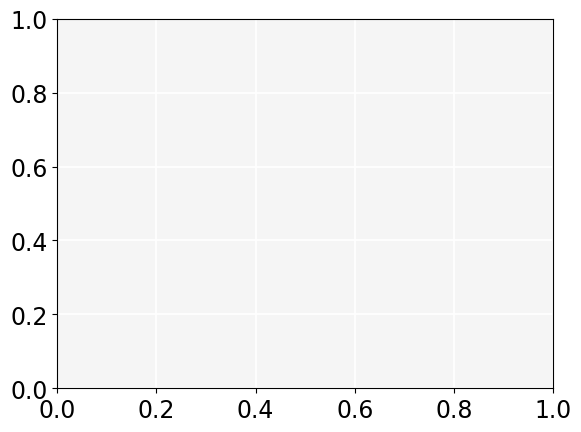

In [35]:
# Record once every 100 iterations, and 10 workers need to communicate in each iteration
original_num = 1000
k=1
print("original communication number:", original_num)

TASGS_data = pd.read_csv("./result/"+"TASGS-full-iter.csv")
SASG_data = pd.read_csv("./result/"+"SASG-full-iter.csv")
LASG_data = pd.read_csv("./result/"+"LASG-full-iter.csv")
sparse_data = pd.read_csv("./result/"+"Sparse-full-iter.csv")
sgd_data = pd.read_csv("./result/"+"SGD-full-iter.csv")

TASGS_skip = TASGS_data['Skip'].values.tolist()
SASG_skip = SASG_data['Skip'].values.tolist()
LASG_skip = LASG_data['Skip'].values.tolist()

comm_round_TASGS = []
comm_round_SASG = []
comm_round_LASG = []
comm_round_sparse = []
comm_round_dis = []

comm_bit_TASGS = []
comm_bit_SASG = []
comm_bit_LASG = []
comm_bit_sparse = []
comm_bit_dis = []

Eopch_TASGS = []
Eopch_SASG = []
Eopch_LASG = []
Eopch_sparse = []
Eopch_dis = []



comm_num_TASGS, comm_num_SASG, comm_num_LASG, comm_num_sparse, comm_num_dis = 0, 0, 0, 0 ,0
Eopch_n_TASGS,Eopch_n_SASG,Eopch_n_LASG,Eopch_n_sparse,Eopch_n_dis=0,0,0,0,0
for i in range(len(TASGS_skip)):
    
    comm_num_TASGS += original_num
    a= comm_num_TASGS - TASGS_skip[i]
#     print("总轮次",a)
    comm_round_TASGS.append(a)
    
    
for i in range(len(SASG_skip)):
    comm_num_SASG += original_num
    b=comm_num_SASG - SASG_skip[i]

    comm_round_SASG.append(b)

for i in range(len(LASG_skip)):
    comm_num_LASG += original_num
    comm_num_sparse += original_num
    comm_num_dis += original_num
    
    c=comm_num_LASG - LASG_skip[i]


    comm_round_LASG.append(c)
    comm_round_sparse.append(comm_num_sparse)
    comm_round_dis.append(comm_num_dis)


for k in range(20):
    Eopch_n_TASGS += k
    Eopch_n_SASG += k
    Eopch_n_LASG += k
    Eopch_n_sparse += k
    Eopch_n_dis += k
    
    Eopch_TASGS.append(Eopch_n_TASGS)
    Eopch_SASG.append(Eopch_n_SASG)
    Eopch_LASG.append(Eopch_n_LASG)
    Eopch_sparse.append(Eopch_n_sparse)
    Eopch_dis.append(Eopch_n_dis)
    
font1 = {'weight': 'normal', 'size': 17}
font2 = {'weight': 'normal', 'size': 20}

plt.figure()
plt.rc('font', size=17)
plt.subplot(facecolor="whitesmoke")
plt.grid(axis="x", color='w', linestyle='-', which='major', linewidth=1.2)
plt.grid(axis="y", color='w', linestyle='-', which='major', linewidth=1.2)
plt.plot(comm_bit_TASGS, sgd_data['test-acc'].values.tolist(), 'black', label='SGD', linewidth=2.5, linestyle='-')
plt.plot(comm_bit_SASG, sparse_data['test-acc'].values.tolist(), 'b', label='Sparse', linewidth=2.5, linestyle='-')
plt.plot(comm_bit_LASG, LASG_data['test-acc'].values.tolist(), 'g', label='LASG', linewidth=2.5)
plt.plot(comm_bit_sparse, SASG_data['test-acc'].values.tolist(), 'r', label='SASG', linewidth=2.5)
plt.plot(comm_bit_dis, TASGS_data['test-acc'].values.tolist(), 'c', label='GSASG', linewidth=2.5)
ax = plt.gca()
xmajorLocator = MultipleLocator(40000)  # major
ax.xaxis.set_major_locator(xmajorLocator)
xminorLocator = MultipleLocator(20000)  # minor
ax.xaxis.set_minor_locator(xminorLocator)
ax.ticklabel_format(axis='x', style='scientific', scilimits=(0, 0))
plt.xlabel('Communication Round', font2)
plt.ylim(88, 99)
ymajorLocator = MultipleLocator(2)  # major
ax.yaxis.set_major_locator(ymajorLocator)
yminorLocator = MultipleLocator(1)  # minor
ax.yaxis.set_minor_locator(yminorLocator)
plt.ylabel('Test Accuracy', font2)



legend = plt.legend(prop=font1)
plt.subplots_adjust(left=0.13, right=0.95, bottom=0.15, top=0.95)

plt.savefig("./result/"+"test_full.png", dpi=600)
plt.show()

plt.figure()
plt.rc('font', size=17)
plt.subplot(facecolor="whitesmoke")
plt.grid(axis="x", color='w', linestyle='-', which='major', linewidth=1.2)
plt.grid(axis="y", color='w', linestyle='-', which='major', linewidth=1.2)
plt.plot(comm_round_dis, sgd_data['Loss'].values.tolist(), 'black', label='SGD', linewidth=2.5, linestyle='-')
plt.plot(comm_round_sparse, sparse_data['Loss'].values.tolist(), 'b', label='Sparse', linewidth=2.5, linestyle='-.')
plt.plot(comm_round_LASG, LASG_data['Loss'].values.tolist(), 'g', label='LASG', linewidth=2.5)
plt.plot(comm_round_SASG, SASG_data['Loss'].values.tolist(), 'r', label='SASG', linewidth=2.5)
plt.plot(comm_round_TASGS, TASGS_data['Loss'].values.tolist(), 'c', label='GSASG', linewidth=2.5)
ax = plt.gca()
xmajorLocator = MultipleLocator(40000)  # major
ax.xaxis.set_major_locator(xmajorLocator)
xminorLocator = MultipleLocator(20000)  # minor
ax.xaxis.set_minor_locator(xminorLocator)
ax.ticklabel_format(axis='x', style='scientific', scilimits=(0, 0))
plt.xlabel('Communication Round', font2)
plt.yscale('log')
plt.ylabel('Loss', font2)
legend = plt.legend(prop=font1)
plt.subplots_adjust(left=0.16, right=0.95, bottom=0.15, top=0.95)
plt.savefig("./result/"+"loss_full.png", dpi=600)
plt.show()

original communication number: 1000
[299.0, 630.0, 957.0, 1281.0, 1601.0, 1918.0, 2242.0, 2562.0, 2879.0, 3201.0, 3527.0, 3858.0, 4189.0, 4530.0, 4869.0, 5213.0, 5554.0, 5882.0, 6214.0, 6554.0, 6891.0, 7234.0, 7577.0, 7918.0, 8263.0, 8602.0, 8941.0, 9282.0, 9628.0, 9967.0, 10314.0, 10660.0, 11001.0, 11346.0, 11682.0, 12023.0, 12365.0, 12704.0, 13050.0, 13392.0, 13739.0, 14079.0, 14428.0, 14772.0, 15115.0, 15459.0, 15807.0, 16148.0, 16498.0, 16851.0, 17194.0, 17544.0, 17891.0, 18244.0, 18588.0, 18937.0, 19282.0, 19632.0, 19974.0, 20318.0]


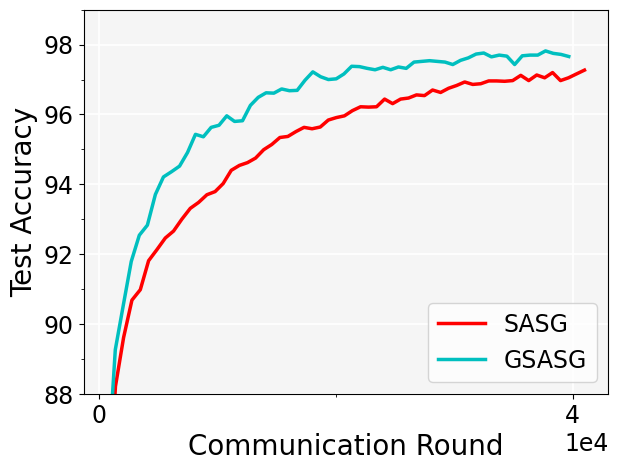

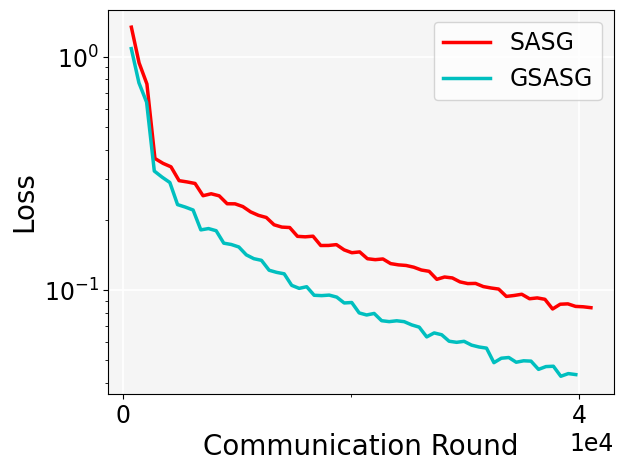

In [3]:
# Record once every 100 iterations, and 10 workers need to communicate in each iteration
original_num = 1000
print("original communication number:", original_num)

TASGS_data = pd.read_csv("./result/"+"TASGS-full-iter.csv")
SASG_data = pd.read_csv("./result/"+"SASG-full-iter.csv")


TASGS_skip = TASGS_data['Skip'].values.tolist()
print(TASGS_skip)
SASG_skip = SASG_data['Skip'].values.tolist()


comm_round_TASGS = []
comm_round_SASG = []

comm_bit_TASGS = []
comm_bit_SASG = []





comm_num_TASGS, comm_num_SASG = 0, 0
for i in range(len(TASGS_skip)):
    comm_num_TASGS += original_num
    comm_num_SASG += original_num

    comm_round_TASGS.append(comm_num_TASGS - TASGS_skip[i]) 
    comm_round_SASG.append(comm_num_SASG - SASG_skip[i])


font1 = {'weight': 'normal', 'size': 17}
font2 = {'weight': 'normal', 'size': 20}

plt.figure()
plt.rc('font', size=17)
plt.subplot(facecolor="whitesmoke")
plt.grid(axis="x", color='w', linestyle='-', which='major', linewidth=1.2)
plt.grid(axis="y", color='w', linestyle='-', which='major', linewidth=1.2)

plt.plot(comm_round_SASG, SASG_data['test-acc'].values.tolist(), 'r', label='SASG', linewidth=2.5)
plt.plot(comm_round_TASGS, TASGS_data['test-acc'].values.tolist(), 'c', label='GSASG', linewidth=2.5)
ax = plt.gca()
xmajorLocator = MultipleLocator(40000)  # major
ax.xaxis.set_major_locator(xmajorLocator)
xminorLocator = MultipleLocator(20000)  # minor
ax.xaxis.set_minor_locator(xminorLocator)
ax.ticklabel_format(axis='x', style='scientific', scilimits=(0, 0))
plt.xlabel('Communication Round', font2)


plt.ylim(88, 99)
ymajorLocator = MultipleLocator(2)  # major
ax.yaxis.set_major_locator(ymajorLocator)
yminorLocator = MultipleLocator(1)  # minor
ax.yaxis.set_minor_locator(yminorLocator)
plt.ylabel('Test Accuracy', font2)



legend = plt.legend(prop=font1)
plt.subplots_adjust(left=0.13, right=0.95, bottom=0.15, top=0.95)

plt.savefig("./result/"+"test_full.png", dpi=600)
plt.show()

plt.figure()
plt.rc('font', size=17)
plt.subplot(facecolor="whitesmoke")
plt.grid(axis="x", color='w', linestyle='-', which='major', linewidth=1.2)
plt.grid(axis="y", color='w', linestyle='-', which='major', linewidth=1.2)

plt.plot(comm_round_SASG, SASG_data['Loss'].values.tolist(), 'r', label='SASG', linewidth=2.5)
plt.plot(comm_round_TASGS, TASGS_data['Loss'].values.tolist(), 'c', label='GSASG', linewidth=2.5)
ax = plt.gca()
xmajorLocator = MultipleLocator(40000)  # major
ax.xaxis.set_major_locator(xmajorLocator)
xminorLocator = MultipleLocator(20000)  # minor
ax.xaxis.set_minor_locator(xminorLocator)
ax.ticklabel_format(axis='x', style='scientific', scilimits=(0, 0))
plt.xlabel('Communication Round', font2)
plt.yscale('log')
plt.ylabel('Loss', font2)
legend = plt.legend(prop=font1)
plt.subplots_adjust(left=0.16, right=0.95, bottom=0.15, top=0.95)
plt.savefig("./result/"+"loss_full.png", dpi=600)
plt.show()

Bits/Epoch

original communication number: 1000
[5210240000.0, 10420480000.0, 15630720000.0, 20840960000.0, 26051200000.0, 31261440000.0, 36471680000.0, 41681920000.0, 46892160000.0, 52102400000.0, 57312640000.0, 62522880000.0, 67733120000.0, 72943360000.0, 78153600000.0, 83363840000.0, 88574080000.0, 93784320000.0, 98994560000.0, 104204800000.0, 109415040000.0, 114625280000.0, 119835520000.0, 125045760000.0, 130256000000.0, 135466240000.0, 140676480000.0, 145886720000.0, 151096960000.0, 156307200000.0, 161517440000.0, 166727680000.0, 171937920000.0, 177148160000.0, 182358400000.0, 187568640000.0, 192778880000.0, 197989120000.0, 203199360000.0, 208409600000.0, 213619840000.0, 218830080000.0, 224040320000.0, 229250560000.0, 234460800000.0, 239671040000.0, 244881280000.0, 250091520000.0, 255301760000.0, 260512000000.0, 265722240000.0, 270932480000.0, 276142720000.0, 281352960000.0, 291773440000.0, 296983680000.0, 302193920000.0]
[52096000.0, 104192000.0, 156288000.0, 208384000.0, 260480000.0, 312576

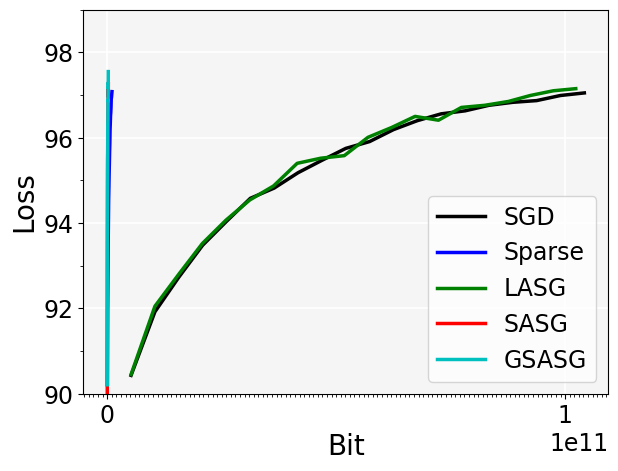

ValueError: x and y must have same first dimension, but have shapes (20,) and (57,)

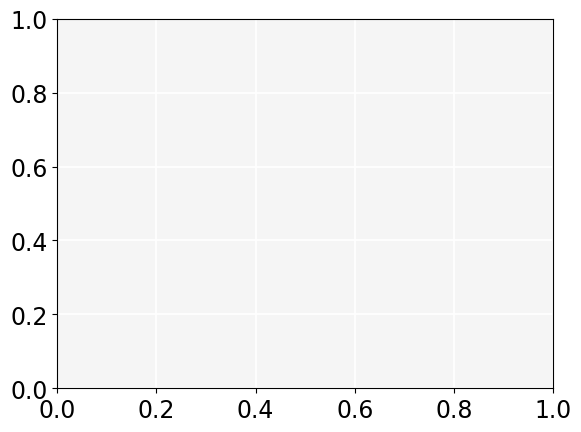

In [33]:
# Record once every 100 iterations, and 10 workers need to communicate in each iteration
original_num = 1000
k=1
print("original communication number:", original_num)

TASGS_data = pd.read_csv("./result/"+"TASGS-full-round.csv")
SASG_data = pd.read_csv("./result/"+"SASG-full-round.csv")
LASG_data = pd.read_csv("./result/"+"LASG-full-round.csv")
sparse_data = pd.read_csv("./result/"+"Sparse-full-round.csv")
sgd_data = pd.read_csv("./result/"+"SGD-full-round.csv")

TASGS_skip = TASGS_data['Skip'].values.tolist()
SASG_skip = SASG_data['Skip'].values.tolist()
LASG_skip = LASG_data['Skip'].values.tolist()

comm_round_TASGS = []
comm_round_SASG = []
comm_round_LASG = []
comm_round_sparse = []
comm_round_dis = []


Eopch_TASGS = []
Eopch_SASG = []
Eopch_LASG = []
Eopch_sparse = []
Eopch_dis = []

comm_bit_TASGS = []
comm_bit_SASG = []
comm_bit_LASG = []
comm_bit_sparse = []
comm_bit_dis = []

comm_num_TASGS, comm_num_SASG, comm_num_LASG, comm_num_sparse, comm_num_dis = 0, 0, 0, 0 ,0
Eopch_n_TASGS,Eopch_n_SASG,Eopch_n_LASG,Eopch_n_sparse,Eopch_n_dis=0,0,0,0,0
for i in range(len(TASGS_skip)):
    
    comm_num_TASGS += original_num
    a= comm_num_TASGS - TASGS_skip[i]
#     print("总轮次",a)
    comm_round_TASGS.append(a)
    
    
for i in range(len(SASG_skip)):
    comm_num_SASG += original_num
    b=comm_num_SASG - SASG_skip[i]

    comm_round_SASG.append(b)

for i in range(len(LASG_skip)):
    comm_num_LASG += original_num
    comm_num_sparse += original_num
    comm_num_dis += original_num
    
    c=comm_num_LASG - LASG_skip[i]


    comm_round_LASG.append(c)
    comm_round_sparse.append(comm_num_sparse)
    comm_round_dis.append(comm_num_dis)


for k in range(20):
    Eopch_n_TASGS += k
    Eopch_n_SASG += k
    Eopch_n_LASG += k
    Eopch_n_sparse += k
    Eopch_n_dis += k
    
    Eopch_TASGS.append(Eopch_n_TASGS)
    Eopch_SASG.append(Eopch_n_SASG)
    Eopch_LASG.append(Eopch_n_LASG)
    Eopch_sparse.append(Eopch_n_sparse)
    Eopch_dis.append(Eopch_n_dis)

 
font1 = {'weight': 'normal', 'size': 17}
font2 = {'weight': 'normal', 'size': 20}
print(sgd_data['commd_round'].values.tolist())
print(sparse_data['commd_round'].values.tolist())
print(LASG_data['commd_round'].values.tolist())
print(SASG_data['commd_round'].values.tolist())
print(TASGS_data['commd_round'].values.tolist())

plt.figure()
plt.rc('font', size=17)
plt.subplot(facecolor="whitesmoke")
plt.grid(axis="x", color='w', linestyle='-', which='major', linewidth=1.2)
plt.grid(axis="y", color='w', linestyle='-', which='major', linewidth=1.2)
plt.plot(sgd_data['commd_round'].values.tolist(), sgd_data['test-acc'].values.tolist(), 'black', label='SGD', linewidth=2.5, linestyle='-')
plt.plot(sparse_data['commd_round'].values.tolist(), sparse_data['test-acc'].values.tolist(), 'b', label='Sparse', linewidth=2.5, linestyle='-')
plt.plot(LASG_data['commd_round'].values.tolist(), LASG_data['test-acc'].values.tolist(), 'g', label='LASG', linewidth=2.5)
plt.plot(SASG_data['commd_round'].values.tolist(), SASG_data['test-acc'].values.tolist(), 'r', label='SASG', linewidth=2.5)
plt.plot(TASGS_data['commd_round'].values.tolist(), TASGS_data['test-acc'].values.tolist(), 'c', label='GSASG', linewidth=2.5)

ax = plt.gca()
xmajorLocator = MultipleLocator(1e11)  # major
ax.xaxis.set_major_locator(xmajorLocator)
xminorLocator = MultipleLocator(1e9)  # minor
ax.xaxis.set_minor_locator(xminorLocator)


ax.ticklabel_format(axis='x', style='scientific', scilimits=(0, 0))
plt.xlabel('Bit', font2)
plt.ylim(90, 99)
ymajorLocator = MultipleLocator(2)  # major
ax.yaxis.set_major_locator(ymajorLocator)
yminorLocator = MultipleLocator(1)  # minor
ax.yaxis.set_minor_locator(yminorLocator)
plt.ylabel('Loss', font2)
legend = plt.legend(prop=font1)
plt.subplots_adjust(left=0.13, right=0.95, bottom=0.15, top=0.95)
plt.savefig("./result/"+"test_full.png", dpi=600)
plt.show()

# plt.figure()
# plt.rc('font', size=17)
# plt.subplot(facecolor="whitesmoke")
# plt.grid(axis="x", color='w', linestyle='-', which='major', linewidth=1.2)
# plt.grid(axis="y", color='w', linestyle='-', which='major', linewidth=1.2)
# plt.plot(Eopch_dis, sgd_data['test-acc'].values.tolist(), 'black', label='SGD', linewidth=2.5, linestyle='-')
# plt.plot(Eopch_sparse, sparse_data['test-acc'].values.tolist(), 'b', label='Sparse', linewidth=2.5, linestyle='-')
# plt.plot(Eopch_LASG, LASG_data['test-acc'].values.tolist(), 'g', label='LASG', linewidth=2.5)
# plt.plot(Eopch_SASG, SASG_data['test-acc'].values.tolist(), 'r', label='SASG', linewidth=2.5)
# plt.plot(Eopch_TASGS, TASGS_data['test-acc'].values.tolist(), 'c', label='GSASG', linewidth=2.5)

# ax = plt.gca()
# xmajorLocator = MultipleLocator(40)  # major
# ax.xaxis.set_major_locator(xmajorLocator)
# xminorLocator = MultipleLocator(20)  # minor
# ax.xaxis.set_minor_locator(xminorLocator)
# ax.ticklabel_format(axis='x', style='scientific', scilimits=(0, 0))
# plt.xlabel('Epoch', font2)
# plt.yscale('log')
# plt.ylabel('Test Accyracy', font2)
# legend = plt.legend(prop=font1)
# plt.subplots_adjust(left=0.16, right=0.95, bottom=0.15, top=0.95)
# plt.savefig("./result/"+"loss_full.png", dpi=600)
# plt.show()
plt.figure()
plt.rc('font', size=17)
plt.subplot(facecolor="whitesmoke")
plt.grid(axis="x", color='w', linestyle='-', which='major', linewidth=1.2)
plt.grid(axis="y", color='w', linestyle='-', which='major', linewidth=1.2)
plt.plot(Eopch_dis ,sgd_data['Loss'].values.tolist(), 'black', label='SGD', linewidth=2.5, linestyle='-')
plt.plot(Eopch_sparse, sparse_data['Loss'].values.tolist(), 'b', label='Sparse', linewidth=2.5, linestyle='-')
plt.plot(Eopch_LASG, LASG_data['Loss'].values.tolist(), 'g', label='LASG', linewidth=2.5)
plt.plot(Eopch_SASG, SASG_data['Loss'].values.tolist(), 'r', label='SASG', linewidth=2.5)
plt.plot(Eopch_TASGS, TASGS_data['Loss'].values.tolist(), 'c', label='GSASG', linewidth=2.5)
ax = plt.gca()
xmajorLocator = MultipleLocator(40)  # major
ax.xaxis.set_major_locator(xmajorLocator)
xminorLocator = MultipleLocator(20)  # minor
ax.xaxis.set_minor_locator(xminorLocator)
ax.ticklabel_format(axis='x', style='scientific', scilimits=(0, 0))
plt.xlabel('Epoch', font2)
plt.yscale('log')
plt.ylabel('Loss', font2)
legend = plt.legend(prop=font1)
plt.subplots_adjust(left=0.16, right=0.95, bottom=0.15, top=0.95)
plt.savefig("./result/"+"loss_full.png", dpi=600)
plt.show()

k‘的变化

original communication number: 1000


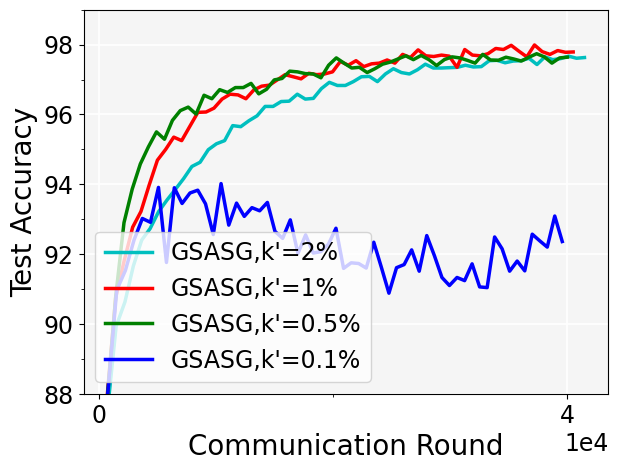

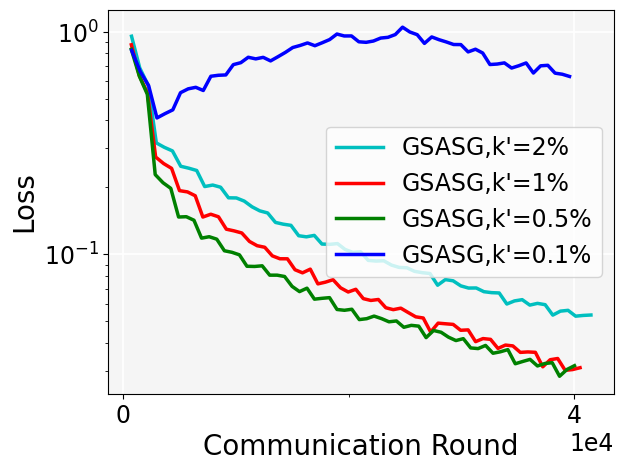

In [51]:
# Record once every 100 iterations, and 10 workers need to communicate in each iteration
original_num = 1000
print("original communication number:", original_num)

TASGS_data = pd.read_csv("./result/"+"TASGS-full-iter-0.03.csv")
TASGS1_data = pd.read_csv("./result/"+"TASGS1-full-iter-0.03.csv")
TASGS2_data = pd.read_csv("./result/"+"TASGS2-full-iter-0.03.csv")
TASGS3_data = pd.read_csv("./result/"+"TASGS3-full-iter-0.03.csv")

TASGS_skip = TASGS_data['Skip'].values.tolist()
TASGS1_skip = TASGS1_data['Skip'].values.tolist()
TASGS2_skip = TASGS2_data['Skip'].values.tolist()
TASGS3_skip = TASGS3_data['Skip'].values.tolist()


comm_round_TASGS = []
comm_round_TASGS1 = []
comm_round_TASGS2 = []
comm_round_TASGS3 = []


comm_bit_TASGS = []
comm_bit_TASGS1 = []
comm_bit_TASGS2 = []
comm_bit_TASGS3 = []





comm_num_TASGS, comm_num_TASGS1, comm_num_TASGS2, comm_num_TASGS3 = 0, 0, 0, 0
for i in range(len(TASGS_skip)):
    comm_num_TASGS += original_num 
    comm_round_TASGS.append(comm_num_TASGS - TASGS_skip[i]) 
    
    
for i in range(len(TASGS1_skip)):
    comm_num_TASGS1 += original_num 
    comm_round_TASGS1.append(comm_num_TASGS1 - TASGS1_skip[i]) 
    
    
for i in range(len(TASGS2_skip)):
    comm_num_TASGS2 += original_num 
    comm_round_TASGS2.append(comm_num_TASGS2 - TASGS2_skip[i]) 
    
    
for i in range(len(TASGS3_skip)):
    comm_num_TASGS3 += original_num 
    comm_round_TASGS3.append(comm_num_TASGS3 - TASGS3_skip[i]) 



font1 = {'weight': 'normal', 'size': 17}
font2 = {'weight': 'normal', 'size': 20}

plt.figure()
plt.rc('font', size=17)
plt.subplot(facecolor="whitesmoke")
plt.grid(axis="x", color='w', linestyle='-', which='major', linewidth=1.2)
plt.grid(axis="y", color='w', linestyle='-', which='major', linewidth=1.2)

plt.plot(comm_round_TASGS, TASGS_data['test-acc'].values.tolist(), 'c', label="GSASG,k'=2%", linewidth=2.5)
plt.plot(comm_round_TASGS1, TASGS1_data['test-acc'].values.tolist(), 'r', label="GSASG,k'=1%", linewidth=2.5)
plt.plot(comm_round_TASGS2, TASGS2_data['test-acc'].values.tolist(), 'g', label="GSASG,k'=0.5%", linewidth=2.5)
plt.plot(comm_round_TASGS3, TASGS3_data['test-acc'].values.tolist(), 'b', label="GSASG,k'=0.1%", linewidth=2.5)

ax = plt.gca()
xmajorLocator = MultipleLocator(40000)  # major
ax.xaxis.set_major_locator(xmajorLocator)
xminorLocator = MultipleLocator(20000)  # minor
ax.xaxis.set_minor_locator(xminorLocator)
ax.ticklabel_format(axis='x', style='scientific', scilimits=(0, 0))
plt.xlabel('Communication Round', font2)
plt.ylim(88, 99)
ymajorLocator = MultipleLocator(2)  # major
ax.yaxis.set_major_locator(ymajorLocator)
yminorLocator = MultipleLocator(1)  # minor
ax.yaxis.set_minor_locator(yminorLocator)
plt.ylabel('Test Accuracy', font2)



legend = plt.legend(prop=font1)
plt.subplots_adjust(left=0.13, right=0.95, bottom=0.15, top=0.95)

plt.savefig("./result/"+"test_full.png", dpi=600)
plt.show()

plt.figure()
plt.rc('font', size=17)
plt.subplot(facecolor="whitesmoke")
plt.grid(axis="x", color='w', linestyle='-', which='major', linewidth=1.2)
plt.grid(axis="y", color='w', linestyle='-', which='major', linewidth=1.2)

plt.plot(comm_round_TASGS, TASGS_data['Loss'].values.tolist(), 'c', label="GSASG,k'=2%", linewidth=2.5)
plt.plot(comm_round_TASGS1, TASGS1_data['Loss'].values.tolist(), 'r', label="GSASG,k'=1%", linewidth=2.5)
plt.plot(comm_round_TASGS2, TASGS2_data['Loss'].values.tolist(), 'g', label="GSASG,k'=0.5%", linewidth=2.5)
plt.plot(comm_round_TASGS3, TASGS3_data['Loss'].values.tolist(), 'b', label="GSASG,k'=0.1%", linewidth=2.5)

ax = plt.gca()
xmajorLocator = MultipleLocator(40000)  # major
ax.xaxis.set_major_locator(xmajorLocator)
xminorLocator = MultipleLocator(20000)  # minor
ax.xaxis.set_minor_locator(xminorLocator)
ax.ticklabel_format(axis='x', style='scientific', scilimits=(0, 0))
plt.xlabel('Communication Round', font2)
plt.yscale('log')
plt.ylabel('Loss', font2)
legend = plt.legend(prop=font1)
plt.subplots_adjust(left=0.16, right=0.95, bottom=0.15, top=0.95)
plt.savefig("./result/"+"loss_full.png", dpi=600)
plt.show()